# Using Featuristic With scikit-learn Pipelines

Featuristic is compatible with scikit-learn's powerful `Pipeline` class. This functionality allows you to organize and apply a sequence of data processing steps effortlessly within scikit-learn. With the `Pipeline`, you can chain together various transformers provided by Featuristic or other scikit-learn-compatible libraries. 

These transformers can include feature generation, feature selection, data scaling, and any other preprocessing steps required to prepare your data for modeling.

By leveraging the `Pipeline` class in conjunction with Featuristic, you can streamline your data preprocessing workflow, ensuring consistency and reproducibility. This allows you to construct complex data processing pipelines with ease, and combine Featuristic with model development.

Let's take a look at a very example using the `cars` dataset.

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
import featuristic as ft
import numpy as np

np.random.seed(8888)

print(ft.__version__)

1.0.1


### Load the Data

In [2]:
X, y = ft.fetch_cars_dataset()

X.head()

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin
0,307.0,8,130.0,3504,12.0,70,1
1,350.0,8,165.0,3693,11.5,70,1
2,318.0,8,150.0,3436,11.0,70,1
3,304.0,8,150.0,3433,12.0,70,1
4,302.0,8,140.0,3449,10.5,70,1


In [3]:
y.head()

0    18.0
1    15.0
2    18.0
3    16.0
4    17.0
Name: mpg, dtype: float64

### Split the Data in Train and Test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Objective Function

We define a custom objective function to pass into the Genetic Feature Selection algorithm. The output of this will be minimized to find the optimal subset of features.

In [5]:
def objective(X, y):
    model = LinearRegression()
    scores = cross_val_score(model, X, y, cv=3, scoring="neg_mean_absolute_error")
    return -scores.mean()

### Fit a scikit-learn Pipeline Containing Featuristic

In [6]:
pipe = Pipeline(
    steps=[
        (
            "genetic_feature_synthesis",
            ft.GeneticFeatureSynthesis(
            num_features=5,
            population_size=200,
            max_generations=100,
            early_termination_iters=25,
            parsimony_coefficient=0.035,
            n_jobs=1,
            ),
        ),
        (
            "genetic_feature_selector",
            ft.GeneticFeatureSelector(
                objective,
                population_size=200,
                max_generations=50,
                early_termination_iters=25,
                n_jobs=-1,
            ),
        ),
        (
            "model",
            LinearRegression()
        )
    ]
)

model = pipe.fit(X_train, y_train)

Optimising feature selection...:  52%|█████▏    | 26/50 [00:05<00:05,  4.39it/s]


In [7]:
preds = model.predict(X_test)

preds[:10]

array([13.23930437, 35.40219719, 27.26035025, 26.25423477, 28.24773002,
       19.10148319, 36.15024042, 23.33185658, 31.19121816, 22.29169501])

## Accessing Featuristic Inside the Pipeline

We can still access the individual Featuristic steps via the pipeline's `named_steps` functionality. For example, to look at the formulas used for the feature engineering or to plot the genetic algorithm's history.

In [8]:
gfs = pipe.named_steps["genetic_feature_synthesis"]

gfs.get_feature_info().head()

,name,formula,fitness
0,feature_1,abs(abs(abs((abs(abs(abs(abs(abs(abs(abs(abs(a...,-0.874683
1,feature_8,abs(abs(((cos(((abs(horsepower) / weight) - (s...,-0.847227
2,feature_4,abs(abs((abs(abs(abs(abs(abs(abs(abs(abs(abs(a...,-0.860441
3,feature_5,abs(abs(abs(abs(abs((((cube(horsepower) / (cub...,-0.852704
4,feature_0,abs(abs((model_year / abs(weight)))),-0.880479


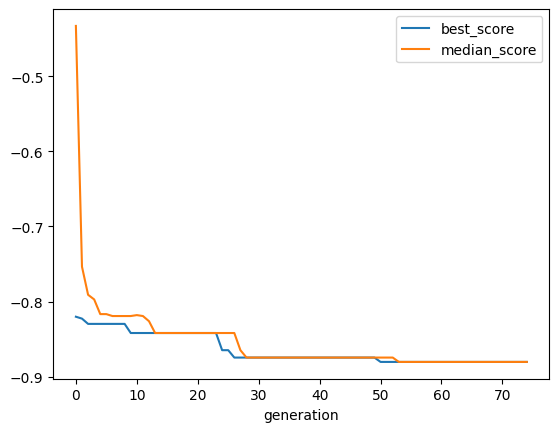

In [9]:
gfs.plot_history()